# ML
* 지도학습
 * 분류
   * Knn, D.T - 사례기반
   * Lr, SGD, SVM - 모델기반
 * 회귀
   * Knn, D.T - 사례기반
   * Lr, SGD, SVM - 모델기반
* 비지도학습
 * 사례기반, 모델기반

# Ensemble Learning(앙상블 학습 방법)

* 앙상블(ensemble): 머신 러닝에서 사용되는 일련의 모델(알고리즘)들.
    * 서로 다른 모델 여러개를 학습시키는 방법.
    * 한 가지 모델을 서로 다른 훈련 셋에서 학습시키는 방법.
* 앙상블 학습 방법 : 앙상블을 사용한 머신러닝 방법
    * 투표(voting) 방식: 여러 모델을 학습시켜서 각각의 예측값들을 투표(다수결) 또는 평균값으로 예측하는 방식
    * __Bagging(Bootstrap Aggregating)__: 중복을 허용해서 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측(다수결, 평균)하는 방법.
    * Pasting: 중복을 허용하지 않고 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측하는 방법.
    * Gradient Boost : 잔여 오차(residual errors)들을 다음 훈련에서 학습시켜서 강한 학습기를 만드는 Boosting 방법
* __Random Forest__: Bagging을 사용한 Decision Tree들의 Ensemble 학습 방법.


#Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier #사례기반 알고리즘의 대표적인 분류기
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  # SVM(Support Vector Machine)을 사용한 분류 알고리즘.
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier

# Dataset 준비

2개의 특성(x1, x2)과 2개의 클래스(0,1)를 갖는 가상의 데이터 생성
* 타겟이 몇개의 종류를 갖고 있느냐, 
레이블이 갖고 있는 카테고리의 의미인 클래스

In [ ]:
# X: 특성 행렬(2차원 배열), y: 타겟 배열(레이블 배열)
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

In [ ]:
X.shape, y.shape

((500, 2), (500,))

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([250, 250]))

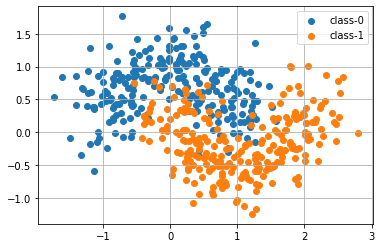

In [ ]:
# X, y 를 시각화
plt.scatter(X[y == 0, 0], X[y==0, 1],label='class-0')
plt.scatter(X[y == 1, 0], X[y==1, 1],label='class-1')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 훈련/테스트 셋 분리
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

# 머신 러닝 모델의 성능 비교

* 여러개의 머신 러닝 모델들을 훈련 셋(X_train, y_train)으로 학습시킴.
 * KNN, Logistic Regression, SGD, Decision Tree, SVM
   * SGDClassifier의 파라미터 중에서 loss='log'를 사용 
     * 확률 계산하기 위해서 디폴트 hinge를 log로 바꾸는 것!
   * SVC의 파라미터 중에서 probability=True를 사용.
* 훈련된 각 모델의 교차 검증 점수(정확도)를 계산, 평가

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)
tree = DecisionTreeClassifier(random_state=42)
logistic = LogisticRegression(random_state=42, n_jobs=-1)
sgd = SGDClassifier(loss='log', random_state=42, n_jobs=-1)
#> loss='log': 각 클래스가 될 확률을 계산해서 예측하기 위해서.
svm = SVC(probability=True, random_state=42)
#> probability=True: 각 클래스가 될 확률을 계산해서 예측하기 위해서.

In [ ]:
classifiers = [knn, tree, logistic, sgd, svm]  # 반복문에서 사용하기 위해서

In [ ]:
knn.__class__.__name__

'KNeighborsClassifier'

In [ ]:
for clf in classifiers:
    clf.fit(X_tr, y_tr)  # 분류기를 훈련 데이터에 학습시킴.
    tr_acc = clf.score(X_tr, y_tr)  # 훈련 셋 정확도
    te_acc = clf.score(X_te, y_te)  # 테스트 셋 정확도
    print(f'{clf.__class__.__name__} - train acc:{tr_acc}, test acc:{te_acc}')

KNeighborsClassifier - train acc:0.93, test acc:0.93
DecisionTreeClassifier - train acc:1.0, test acc:0.84
LogisticRegression - train acc:0.8475, test acc:0.81
SGDClassifier - train acc:0.8425, test acc:0.81
SVC - train acc:0.9275, test acc:0.93


# Voting Enesemble

In [ ]:
vote_clf = VotingClassifier(estimators=[('knn', knn),
                                        ('tree', tree),
                                        ('logistic', logistic),
                                        ('sgd', sgd),
                                        ('svm', svm)],
                            voting='soft',
                            n_jobs=-1)
# VotingClassifier 파라미터
#> estimators: 투표 방식 앙상블을 만들기 위한 ML 모델들의 튜플들의 리스트('모델이름', 모델 객체)
#> voting: 투표 방식
#>> hard: 모든 앙상블들이 동일하게 1표씩 행사. 예측 확률을 계산할 필요가 없음.
#>> soft: 각 모델의 예측값에 각 모델에서 예측된 예측 확률을 가중치로 곱한 값을 사용해서 예측.
# 일반적으로, soft voting 방식이 hard voting 방식보다 성능 더 좋다고 알려져 있음.

In [ ]:
# voting ensemble을 훈련
vote_clf.fit(X_tr,y_tr)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_jobs=-1)),
                             ('tree', DecisionTreeClassifier(random_state=42)),
                             ('logistic',
                              LogisticRegression(n_jobs=-1, random_state=42)),
                             ('sgd',
                              SGDClassifier(loss='log', n_jobs=-1,
                                            random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 n_jobs=-1, voting='soft')

In [ ]:
# 훈련/테스트 셋 정확도
print('train acc:', vote_clf.score(X_tr, y_tr))
print('test acc:', vote_clf.score(X_te, y_te))

train acc: 0.94
test acc: 0.92


# Bagging(Bootstrap Aggregating) Ensemble

BaggingClasifier의 파라미터들:

*   base_estimator: 기본 추정기(예측기). 머신 러닝 모델 객체.
*   n_etimators: 추정기(예측기)의 개수. 기본값 10.
*   max_samples: 훈련 셋의 부분 집합이 가질 수 있는 최대 샘플 개수(정수) 또는 비율(0 ~ 1.0). 기본값은 1.0.
*   bootstrap: True(중복 허용 샘플링, bagging). False(중복 불허 샘플링, pasting). 기본값은 True.
*   oob_score: True(OOB 샘플로 평가 점수 계산). False(OOB 샘플로 평가 점수를 계산하지 않음). 기본값은 False.
    *   OOB(Out-Of-Bagging) 샘플: 중복 허용 샘플링을 하는 동안 한 번도 샘플링되지 못하고 남아 있는 훈련 셋의 샘플.
    *   OOB sample은 validation set 역할을 할 수 있음.

In [ ]:
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    max_samples=100,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

In [ ]:
bagging_clf.fit(X_tr,y_tr) #모델 훈련

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=50, n_jobs=-1, oob_score=True,
                  random_state=42)

In [ ]:
bagging_clf.oob_score_
# OOB(out-of-bagging) 배깅에서 제외된 샘플들로 계산한 점수(정확도)
# oob_score_는 일반적으로 테스트 셋 점수보다 약간 좋거나 비슷.

0.91

In [ ]:
# 훈련/테스트 셋 정확도
print('train acc:', bagging_clf.score(X_tr, y_tr))
print('test acc:', bagging_clf.score(X_te, y_te))

train acc: 0.9425
test acc: 0.9


In [ ]:
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_samples=1.0,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

In [ ]:
cv = cross_validate(bagging_clf, X_tr, y_tr, n_jobs=-1, return_train_score=True)

In [ ]:
print('train score:', np.mean(cv['train_score']))
print('test score:', np.mean(cv['test_score']))

train score: 1.0
test score: 0.9075


# Random Forest

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=50, max_samples=100, oob_score=True,
                                    random_state=42, n_jobs=-1)

In [ ]:
forest_clf.fit(X_tr,y_tr)

RandomForestClassifier(max_samples=100, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42)

In [ ]:
forest_clf.oob_score_

0.9125

In [ ]:
print('train score:', forest_clf.score(X_tr,y_tr))
print('test score:', forest_clf.score(X_te,y_te))

train score: 0.9475
test score: 0.91


Random Forest: Decision Tree를 사용하는 bagging ensemble 학습 방법.
* DecisionTree의 파라미터와 Bagging의 파라미터들을 갖음.
* GridSearchCV, RandomizedSearchCV을 사용해서 tree와 bagging의 하이퍼 파라미터들을 튜닝할 수 있음.

# Wine 데이터셋 (rea, white 구분)

In [ ]:
wine_csv ='http://bit.ly/wine_csv_data'

In [ ]:
wine= pd.read_csv(wine_csv)

In [ ]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [ ]:
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [ ]:
X = wine.iloc[:,:3].values.copy()
y = wine['class'].values.copy()

In [ ]:
X.shape, y.shape

((6497, 3), (6497,))

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, 
                                          test_size=0.2,
                                          stratify=y,
                                          random_state=42)

In [ ]:
random = RandomForestClassifier(n_estimators=50,max_depth=9,
                                max_samples=100,oob_score=True,
                                random_state=42)

In [ ]:
# GridSearchCV 사용해보기
from sklearn.model_selection import GridSearchCV
param_grid={'max_depth': np.arange(1,10)}
grid= GridSearchCV(estimator=random, param_grid=param_grid, n_jobs=-1)
grid.fit(X_tr,y_tr)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [ ]:
grid.best_params_

{'max_depth': 9}

In [ ]:
random.fit(X_tr,y_tr)

RandomForestClassifier(max_depth=9, max_samples=100, n_estimators=50,
                       oob_score=True, random_state=42)

In [ ]:
random.oob_score_

0.8633827208004619

In [ ]:
random.score(X_te,y_te)

0.8530769230769231

In [ ]:
te_pred = random.predict(X_te)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_te,te_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.62      0.68       320
         1.0       0.88      0.93      0.91       980

    accuracy                           0.85      1300
   macro avg       0.81      0.78      0.79      1300
weighted avg       0.85      0.85      0.85      1300



# breast_cancer (악성,양성 종양 분류)

In [ ]:
# sklearn에 내장되어있는 datasets
cancer = datasets.load_breast_cancer()

In [ ]:
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [ ]:
X= cancer['data']
y= cancer['target']
# bench는 ndarray가 안되므로 values를 사용할 수 없다.

In [ ]:
X.shape, y.shape

((569, 30), (569,))

In [ ]:
cancer['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [ ]:
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X,y,
                                          test_size=0.2,
                                          random_state=42,
                                          stratify=y)

In [ ]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                               max_depth=5, random_state=42,
                               max_samples=100,oob_score=True)

In [ ]:
model.fit(X_tr,y_tr)

RandomForestClassifier(max_depth=5, max_samples=100, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42)

In [ ]:
model.oob_score_

0.9494505494505494

In [ ]:
model.score(X_tr,y_tr)

0.9714285714285714

In [ ]:
model.score(X_te,y_te)

0.9385964912280702

In [ ]:
te_pred = model.predict(X_te)

In [ ]:
print(classification_report(y_te,te_pred,target_names=cancer.target_names))

              precision    recall  f1-score   support

   malignant       0.91      0.93      0.92        42
      benign       0.96      0.94      0.95        72

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

